In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers, Model
from sklearn.model_selection import train_test_split

from keras import Model
from keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tqdm import tqdm

LR images directory: C:/Users/Admin/Desktop/AIMS_2023_2024_DOCS/Review_phase/Thesis_project/FOR_NEW_CODE\chest_xray/LR_32_images
HR images directory: C:/Users/Admin/Desktop/AIMS_2023_2024_DOCS/Review_phase/Thesis_project/FOR_NEW_CODE\chest_xray/HR_128_images
Contents of LR images directory: ['BACTERIA-1008087-0001.jpeg', 'BACTERIA-1025587-0001.jpeg', 'BACTERIA-1027194-0001.jpeg', 'BACTERIA-1033441-0001.jpeg', 'BACTERIA-103798-0001.jpeg']
Contents of HR images directory: ['BACTERIA-1008087-0001.jpeg', 'BACTERIA-1025587-0001.jpeg', 'BACTERIA-1027194-0001.jpeg', 'BACTERIA-1033441-0001.jpeg', 'BACTERIA-103798-0001.jpeg']
Loading images from C:/Users/Admin/Desktop/AIMS_2023_2024_DOCS/Review_phase/Thesis_project/FOR_NEW_CODE\chest_xray/LR_32_images and C:/Users/Admin/Desktop/AIMS_2023_2024_DOCS/Review_phase/Thesis_project/FOR_NEW_CODE\chest_xray/HR_128_images


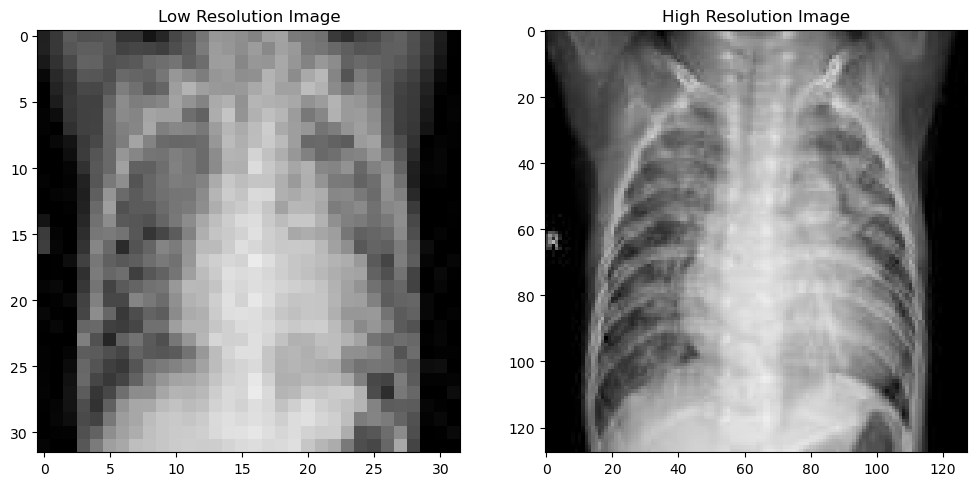

In [2]:
# Define function to load and resize images
def load_resize_images(lr_path, hr_path, lr_shape, hr_shape, n):
    print(f"Loading images from {lr_path} and {hr_path}")
    
    if not os.path.exists(lr_path):
        raise FileNotFoundError(f"The low-resolution image directory does not exist: {lr_path}")
    if not os.path.exists(hr_path):
        raise FileNotFoundError(f"The high-resolution image directory does not exist: {hr_path}")
    
    lr_list = os.listdir(lr_path)[:n]
    hr_list = os.listdir(hr_path)[:n]
    
    lr_images = []
    hr_images = []
    
    for img in lr_list:
        img_lr_path = os.path.join(lr_path, img)
        img_lr = cv2.imread(img_lr_path)
        if img_lr is None:
            print(f"Failed to load image: {img_lr_path}")
            continue
        img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
        img_lr = cv2.resize(img_lr, (lr_shape[0], lr_shape[1]))
        lr_images.append(img_lr)
    
    for img in hr_list:
        img_hr_path = os.path.join(hr_path, img)
        img_hr = cv2.imread(img_hr_path)
        if img_hr is None:
            print(f"Failed to load image: {img_hr_path}")
            continue
        img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
        img_hr = cv2.resize(img_hr, (hr_shape[0], hr_shape[1]))
        hr_images.append(img_hr)
    
    lr_images = np.array(lr_images) / 255.
    hr_images = np.array(hr_images) / 255.
    
    return lr_images, hr_images

# Define the base directory where your project is located
base_dir = "C:/Users/Admin/Desktop/AIMS_2023_2024_DOCS/Review_phase/Thesis_project/FOR_NEW_CODE"

# Define the paths to the LR and HR image directories
lr_images_dir = os.path.join(base_dir, "chest_xray/LR_32_images")
hr_images_dir = os.path.join(base_dir, "chest_xray/HR_128_images")

# Print the paths to verify
print(f"LR images directory: {lr_images_dir}")
print(f"HR images directory: {hr_images_dir}")

# Check if directories exist and list their contents
if os.path.exists(lr_images_dir):
    print(f"Contents of LR images directory: {os.listdir(lr_images_dir)[:5]}")
else:
    print(f"LR images directory does not exist: {lr_images_dir}")

if os.path.exists(hr_images_dir):
    print(f"Contents of HR images directory: {os.listdir(hr_images_dir)[:5]}")
else:
    print(f"HR images directory does not exist: {hr_images_dir}")

# Define input pairs of LR and HR image shapes
image_pairs = {
    "pair1": [(32, 32, 3), (128, 128, 3)],
    "pair2": [(64, 64, 3), (256, 256, 3)],
    "pair3": [(128, 128, 3), (512, 512, 3)]
}

# Choose the image pair to use
chosen_pair = "pair1"  # Change this to select a different pair

# Get the LR and HR shapes for the chosen pair
lr_shape, hr_shape = image_pairs[chosen_pair]

# Load and resize images
lr_images, hr_images = load_resize_images(lr_images_dir, hr_images_dir, lr_shape, hr_shape, n=510)

# Sanity check: Display a random image from the dataset
import random
image_number = random.randint(0, len(lr_images)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(lr_images[image_number])
plt.title("Low Resolution Image")
plt.subplot(122)
plt.imshow(hr_images[image_number])
plt.title("High Resolution Image")
plt.show()

# Split the dataset
train_lr, test_lr, train_hr, test_hr = train_test_split(lr_images, hr_images, test_size=0.33, random_state=42)

# Define input layers
lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)

# Continue with the rest of your code...


In [3]:
# generator

# Residual block
def res_block(ip):
    
    res_model = Conv2D(64, (3,3), padding = "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)
    
    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    
    return add([ip,res_model])
# Upscale the image 2x
def upscale_block(ip):
    
    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 2 )(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)
    
    return up_model
num_res_block = 16
# Generator Model
def create_gen(gen_ip):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)
    temp = layers
    for i in range(num_res_block):
        layers = res_block(layers)
    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])
    layers = upscale_block(layers)
    layers = upscale_block(layers)
    op = Conv2D(3, (9,9), padding="same")(layers)
    return Model(inputs=gen_ip, outputs=op)

In [4]:
# Discriminator

# Small block inside the discriminator
def discriminator_block(ip, filters, strides=1, bn=True):
    
    disc_model = Conv2D(filters, (3,3), strides, padding="same")(ip)
    disc_model = LeakyReLU( alpha=0.2 )(disc_model)
    if bn:
        disc_model = BatchNormalization( momentum=0.8 )(disc_model)
    return disc_model
# Discriminator Model
def create_disc(disc_ip):
    df = 64
    
    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)
    
    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)
    return Model(disc_ip, validity)

In [5]:
# define vgg19

from keras.applications import VGG19

def build_vgg(hr_shape):
    
    vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)
    
    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)

In [6]:
# combined model

# Attach the generator and discriminator
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)
    gen_features = vgg(gen_img)
    disc_model.trainable = False
    validity = disc_model(gen_img)
    return Model([lr_ip, hr_ip],[validity,gen_features])

In [7]:
# optimize a model 

generator = create_gen(lr_ip)
discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam",      
  metrics=['accuracy'])
#vgg = build_vgg()
if chosen_pair == "pair1":
    vgg=build_vgg((128,128,3))  #vgg=build_vgg((128,128,3))
elif chosen_pair == "pair2":
    vgg=build_vgg((256,256,3))
else:
    vgg=build_vgg((512,512,3))
    
vgg.trainable = False
print(vgg.summary())
gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)
gan_model.compile(loss=["binary_crossentropy","mse"], loss_weights=
  [1e-3, 1], optimizer="adam")



Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0 

In [8]:
gan_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 model (Functional)          (None, 128, 128, 3)          2044291   ['input_1[0][0]']             
                                                                                                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 model_1 (Functional)        (None, 1)                    3824928   ['model[0][0]']               
                                                          1                                 

In [9]:
# training a model

batch_size = 20
train_lr_batches = []
train_hr_batches = []
for it in range(int(train_hr.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(train_hr[start_idx:end_idx])
    train_lr_batches.append(train_lr[start_idx:end_idx])
train_lr_batches = np.array(train_lr_batches)
train_hr_batches = np.array(train_hr_batches)

In [10]:
epochs = 80
gen_losses_store=[]
dis_losses_store=[]
increment=0
for e in range(epochs):
    gen_label = np.zeros((batch_size, 1))
    real_label = np.ones((batch_size,1))
    g_losses = []
    d_losses = []
    for b in range(len(train_hr_batches)):
        lr_imgs = train_lr_batches[b]
        hr_imgs = train_hr_batches[b]
        gen_imgs = generator.predict_on_batch(lr_imgs)
        #Dont forget to make the discriminator trainable
        discriminator.trainable = True
        
        #Train the discriminator
        d_loss_gen = discriminator.train_on_batch(gen_imgs,
          gen_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs,
          real_label)
        discriminator.trainable = False
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real)
        image_features = vgg.predict(hr_imgs)
        
        #Train the generator
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], 
          [real_label, image_features])
        
        d_losses.append(d_loss)
        g_losses.append(g_loss)
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)
    
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)
    print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)
    
    ## loss_displaying
    gen_losses_store.append(g_loss)
    dis_losses_store.append(d_loss)
    increment=increment+1



1/1 [==============================] - 1s 917ms/step
epoch: 1 g_loss: 144.99948277192956 d_loss: [20.69894671  0.77941176]
1/1 [==============================] - 1s 918ms/step
epoch: 2 g_loss: 46.09684147554285 d_loss: [3.27241387 0.93823529]
1/1 [==============================] - 1s 812ms/step
epoch: 3 g_loss: 38.192749472225415 d_loss: [0.17819077 0.99264706]
1/1 [==============================] - 1s 792ms/step
epoch: 4 g_loss: 33.04911299312816 d_loss: [0.05943304 0.99705882]
1/1 [==============================] - 1s 814ms/step
epoch: 5 g_loss: 29.189960591933307 d_loss: [0.1983031  0.98823529]
1/1 [==============================] - 1s 818ms/step
epoch: 6 g_loss: 26.307644787956686 d_loss: [14.32308192  0.67941176]
1/1 [==============================] - 1s 859ms/step
epoch: 7 g_loss: 23.115276336669922 d_loss: [0.87477834 0.90735294]
1/1 [==============================] - 1s 875ms/step
epoch: 8 g_loss: 20.265897526460535 d_loss: [0.48601188 0.93382353]


1/1 [==============================] - 1s 828ms/step
epoch: 9 g_loss: 18.492375317741843 d_loss: [0.17133646 0.96911764]
1/1 [==============================] - 1s 844ms/step
epoch: 10 g_loss: 16.96601604012882 d_loss: [0.09483961 0.98382353]
1/1 [==============================] - 1s 832ms/step
epoch: 11 g_loss: 16.13637015398811 d_loss: [0.08615842 0.97941176]
1/1 [==============================] - 1s 906ms/step
epoch: 12 g_loss: 15.285760430728688 d_loss: [0.00218942 1.        ]
1/1 [==============================] - 1s 876ms/step
epoch: 13 g_loss: 14.543464380152086 d_loss: [9.53587184e-04 1.00000000e+00]
1/1 [==============================] - 1s 828ms/step
epoch: 14 g_loss: 14.403741556055406 d_loss: [0.5390676  0.94705882]
1/1 [==============================] - 1s 735ms/step
epoch: 15 g_loss: 13.65154675876393 d_loss: [1.51649329 0.84411764]
1/1 [==============================] - 1s 782ms/step
epoch: 16 g_loss: 13.226740276112276 d_loss: [1.21134029 0.91470588]
1/1 [===============

1/1 [==============================] - 1s 938ms/step
epoch: 17 g_loss: 12.792093669666963 d_loss: [2.0428903  0.86029412]
1/1 [==============================] - 1s 766ms/step
epoch: 18 g_loss: 12.558138286366182 d_loss: [1.17509584 0.84264706]
1/1 [==============================] - 1s 750ms/step
epoch: 19 g_loss: 12.186948607949649 d_loss: [0.12438061 0.98382353]
1/1 [==============================] - 1s 797ms/step
epoch: 20 g_loss: 11.895972532384535 d_loss: [0.64436845 0.89705882]
1/1 [==============================] - 1s 771ms/step
epoch: 21 g_loss: 11.929850410012637 d_loss: [2.47489185 0.75294118]
1/1 [==============================] - 1s 786ms/step
epoch: 22 g_loss: 11.394693599027747 d_loss: [0.2763321  0.93235294]
1/1 [==============================] - 1s 849ms/step
epoch: 23 g_loss: 11.224332753349753 d_loss: [0.44395739 0.92352941]
1/1 [==============================] - 1s 812ms/step
epoch: 24 g_loss: 10.77303684459013 d_loss: [0.023116   0.99411765]
1/1 [====================

1/1 [==============================] - 1s 766ms/step
epoch: 25 g_loss: 10.504329793593463 d_loss: [0.0813894  0.98235294]
1/1 [==============================] - 1s 755ms/step
epoch: 26 g_loss: 10.355376580182243 d_loss: [0.04938585 0.9867647 ]
1/1 [==============================] - 1s 826ms/step
epoch: 27 g_loss: 10.27752550910501 d_loss: [0.06536028 0.98529411]
1/1 [==============================] - 1s 871ms/step
epoch: 28 g_loss: 10.12579974006204 d_loss: [0.01789557 0.99117647]
1/1 [==============================] - 1s 894ms/step
epoch: 29 g_loss: 9.938059021444882 d_loss: [0.01305899 0.99705882]
1/1 [==============================] - 1s 840ms/step
epoch: 30 g_loss: 9.592977748197669 d_loss: [0.00482156 0.99852941]
1/1 [==============================] - 1s 806ms/step
epoch: 31 g_loss: 9.558473250445198 d_loss: [0.00395252 0.99852941]
1/1 [==============================] - 1s 800ms/step
epoch: 32 g_loss: 9.584341946770163 d_loss: [0.00538814 0.99852941]
1/1 [=========================

1/1 [==============================] - 1s 803ms/step
epoch: 34 g_loss: 9.169271469116211 d_loss: [0.01055783 0.99558823]
1/1 [==============================] - 1s 766ms/step
epoch: 35 g_loss: 9.017855083241182 d_loss: [0.03283333 0.98970588]
1/1 [==============================] - 1s 750ms/step
epoch: 36 g_loss: 8.721897293539609 d_loss: [0.01209569 0.99117647]
1/1 [==============================] - 1s 771ms/step
epoch: 37 g_loss: 8.579451112186208 d_loss: [0.02758847 0.99117647]
1/1 [==============================] - 1s 751ms/step
epoch: 38 g_loss: 8.61467316571404 d_loss: [5.80405942e-05 1.00000000e+00]
1/1 [==============================] - 1s 816ms/step
epoch: 39 g_loss: 8.547654320211972 d_loss: [9.96146113e-04 1.00000000e+00]
1/1 [==============================] - 1s 1s/step
epoch: 40 g_loss: 8.341431337244371 d_loss: [0.01405875 0.99558823]
1/1 [==============================] - 1s 775ms/step
epoch: 41 g_loss: 8.239297726575066 d_loss: [0.03359353 0.99411765]
1/1 [===============

1/1 [==============================] - 1s 863ms/step
epoch: 42 g_loss: 8.136482743655934 d_loss: [0.15461988 0.96617647]
1/1 [==============================] - 1s 786ms/step
epoch: 43 g_loss: 8.276153171763701 d_loss: [0.31885566 0.93823529]
1/1 [==============================] - 1s 760ms/step
epoch: 44 g_loss: 8.175351479474235 d_loss: [0.02582332 0.98970588]
1/1 [==============================] - 1s 821ms/step
epoch: 45 g_loss: 8.017832559697768 d_loss: [0.08031752 0.98382353]
1/1 [==============================] - 1s 799ms/step
epoch: 46 g_loss: 8.012365761925192 d_loss: [0.04466221 0.99117647]
1/1 [==============================] - 1s 802ms/step
epoch: 47 g_loss: 7.9387274068944595 d_loss: [0.02440308 0.99558823]
1/1 [==============================] - 1s 775ms/step
epoch: 48 g_loss: 7.862783544203815 d_loss: [0.00116423 1.        ]
1/1 [==============================] - 1s 795ms/step
epoch: 49 g_loss: 7.8014227642732505 d_loss: [3.21654677e-04 1.00000000e+00]
1/1 [=================

1/1 [==============================] - 2s 2s/step
epoch: 51 g_loss: 7.554043685688692 d_loss: [3.5514748e-05 1.0000000e+00]
1/1 [==============================] - 1s 766ms/step
epoch: 52 g_loss: 7.509557611802045 d_loss: [1.90520013e-04 1.00000000e+00]
1/1 [==============================] - 1s 755ms/step
epoch: 53 g_loss: 7.536019128911636 d_loss: [4.8942336e-04 1.0000000e+00]
1/1 [==============================] - 1s 787ms/step
epoch: 54 g_loss: 7.611025922438678 d_loss: [9.0349983e-04 1.0000000e+00]
1/1 [==============================] - 1s 776ms/step
epoch: 55 g_loss: 7.499838380252614 d_loss: [0.0088925  0.99705882]
1/1 [==============================] - 1s 750ms/step
epoch: 56 g_loss: 7.263246339910171 d_loss: [0.01310606 0.99264706]
1/1 [==============================] - 1s 755ms/step
epoch: 57 g_loss: 7.1523495561936326 d_loss: [0.01710984 0.99411765]
1/1 [==============================] - 1s 755ms/step
epoch: 58 g_loss: 6.985826324014103 d_loss: [0.02704021 0.99705882]
1/1 [===

1/1 [==============================] - 1s 750ms/step
epoch: 59 g_loss: 7.086584820466883 d_loss: [0.01245099 0.99852941]
1/1 [==============================] - 1s 812ms/step
epoch: 60 g_loss: 7.110057297874899 d_loss: [0.10972504 0.97058823]
1/1 [==============================] - 1s 766ms/step
epoch: 61 g_loss: 7.198024805854349 d_loss: [0.00668574 0.99705882]
1/1 [==============================] - 1s 813ms/step
epoch: 62 g_loss: 7.489661104538861 d_loss: [0.0329433  0.99411765]
1/1 [==============================] - 1s 755ms/step
epoch: 63 g_loss: 7.444622404435101 d_loss: [0.00260478 0.99852941]
1/1 [==============================] - 1s 1s/step
epoch: 64 g_loss: 7.248408570009119 d_loss: [8.64226091e-05 1.00000000e+00]
1/1 [==============================] - 1s 793ms/step
epoch: 65 g_loss: 7.145700651056626 d_loss: [2.63361708e-04 1.00000000e+00]
1/1 [==============================] - 1s 766ms/step
epoch: 66 g_loss: 7.0197838895461135 d_loss: [1.19509521e-04 1.00000000e+00]
1/1 [=====

1/1 [==============================] - 1s 833ms/step
epoch: 68 g_loss: 6.476540761835435 d_loss: [0.00957725 0.99852941]
1/1 [==============================] - 1s 849ms/step
epoch: 69 g_loss: 6.301906810087316 d_loss: [0.00596407 0.99705882]
1/1 [==============================] - 1s 836ms/step
epoch: 70 g_loss: 6.274741369135239 d_loss: [1.74165436 0.90294118]
1/1 [==============================] - 1s 818ms/step
epoch: 71 g_loss: 6.426032683428596 d_loss: [1.23274889 0.83529411]
1/1 [==============================] - 1s 851ms/step
epoch: 72 g_loss: 6.260208887212417 d_loss: [0.02186358 0.99117647]
1/1 [==============================] - 1s 750ms/step
epoch: 73 g_loss: 6.299987821017995 d_loss: [0.06693473 0.98235294]
1/1 [==============================] - 1s 750ms/step
epoch: 74 g_loss: 6.255183444303625 d_loss: [0.0147835  0.99558823]
1/1 [==============================] - 1s 786ms/step
epoch: 75 g_loss: 6.275611821342917 d_loss: [0.01781311 0.99558823]
1/1 [===========================

1/1 [==============================] - 1s 771ms/step
epoch: 76 g_loss: 6.263085393344655 d_loss: [0.04894688 0.99117647]
1/1 [==============================] - 1s 812ms/step
epoch: 77 g_loss: 6.15448559031767 d_loss: [0.00226873 0.99852941]
1/1 [==============================] - 1s 1s/step
epoch: 78 g_loss: 5.988271713256836 d_loss: [0.00133098 1.        ]
1/1 [==============================] - 1s 828ms/step
epoch: 79 g_loss: 5.880055567797492 d_loss: [0.0011879 1.       ]
1/1 [==============================] - 1s 769ms/step
epoch: 80 g_loss: 5.830561329336727 d_loss: [0.00161789 1.        ]


In [11]:
# model evaluation

label = np.ones((len(test_lr),1))
test_features = vgg.predict(test_hr)
eval,_,_ = gan_model.evaluate([test_lr, test_hr], [label,test_features])

6/6 [==============================] - 26s 4s/step - loss: 12.2290 - model_1_loss: 9.9899 - model_2_loss: 12.2191


In [12]:
# model prediction
dis_losses_store

[array([20.69894671,  0.77941176]),
 array([3.27241387, 0.93823529]),
 array([0.17819077, 0.99264706]),
 array([0.05943304, 0.99705882]),
 array([0.1983031 , 0.98823529]),
 array([14.32308192,  0.67941176]),
 array([0.87477834, 0.90735294]),
 array([0.48601188, 0.93382353]),
 array([0.17133646, 0.96911764]),
 array([0.09483961, 0.98382353]),
 array([0.08615842, 0.97941176]),
 array([0.00218942, 1.        ]),
 array([9.53587184e-04, 1.00000000e+00]),
 array([0.5390676 , 0.94705882]),
 array([1.51649329, 0.84411764]),
 array([1.21134029, 0.91470588]),
 array([2.0428903 , 0.86029412]),
 array([1.17509584, 0.84264706]),
 array([0.12438061, 0.98382353]),
 array([0.64436845, 0.89705882]),
 array([2.47489185, 0.75294118]),
 array([0.2763321 , 0.93235294]),
 array([0.44395739, 0.92352941]),
 array([0.023116  , 0.99411765]),
 array([0.0813894 , 0.98235294]),
 array([0.04938585, 0.9867647 ]),
 array([0.06536028, 0.98529411]),
 array([0.01789557, 0.99117647]),
 array([0.01305899, 0.99705882]),
 a

In [13]:
#test_prediction

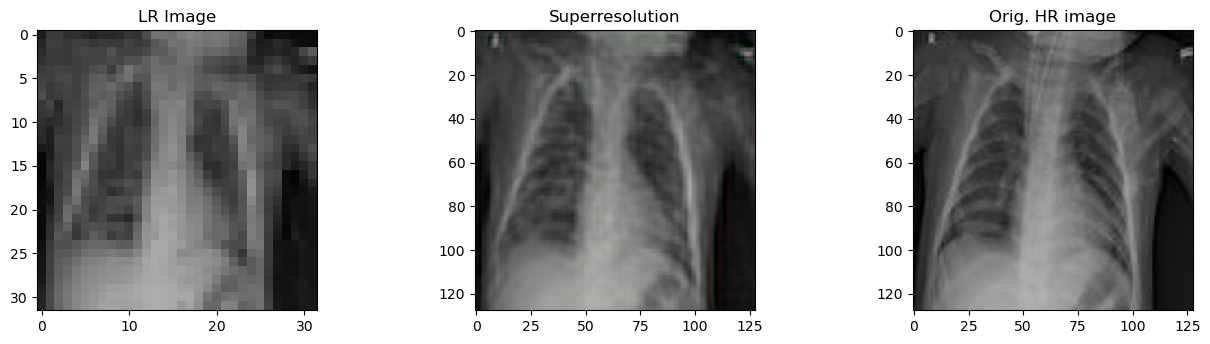

1/1 [==============================] - 1s 1s/step


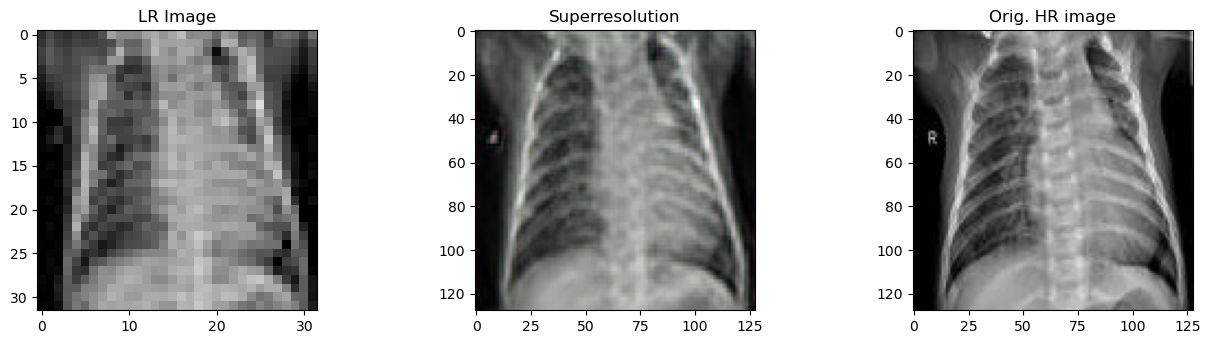

In [14]:
#Test
from keras.models import load_model
from numpy.random import randint


[X1, X2] = [test_lr, test_hr]
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image=generator.predict_on_batch(src_image)


# plot all three images

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(np.clip(src_image[0,:,:,:],0,1))
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(np.clip(gen_image[0,:,:,:],0,1))
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(np.clip(tar_image[0,:,:,:],0,1))

plt.show()


################################################
sreeni_lr = cv2.imread( "C:/Users/Admin/Desktop/AIMS_2023_2024_DOCS/Review_phase/Thesis_project/FOR_NEW_CODE/chest_xray/LR_32_images/BACTERIA-7422-0001.jpeg")
sreeni_hr = cv2.imread("C:/Users/Admin/Desktop/AIMS_2023_2024_DOCS/Review_phase/Thesis_project/FOR_NEW_CODE/chest_xray/HR_128_images/BACTERIA-7422-0001.jpeg")

#Change images from BGR to RGB for plotting. 
#Remember that we used cv2 to load images which loads as BGR.
sreeni_lr = cv2.cvtColor(sreeni_lr, cv2.COLOR_BGR2RGB)
sreeni_hr = cv2.cvtColor(sreeni_hr, cv2.COLOR_BGR2RGB)

sreeni_lr = sreeni_lr / 255.
sreeni_hr = sreeni_hr / 255.

sreeni_lr = np.expand_dims(sreeni_lr, axis=0)
sreeni_hr = np.expand_dims(sreeni_hr, axis=0)

generated_sreeni_hr = generator.predict(sreeni_lr)

# plot all three images
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
#plt.imshow(sreeni_lr[0,:,:,:])
plt.imshow(np.clip(sreeni_lr[0,:,:,:],0,1))
plt.subplot(232)
plt.title('Superresolution')
#plt.imshow(generated_sreeni_hr[0,:,:,:])
plt.imshow(np.clip(generated_sreeni_hr[0,:,:,:],0,1))
plt.subplot(233)
plt.title('Orig. HR image')
#plt.imshow(sreeni_hr[0,:,:,:])
plt.imshow(np.clip(sreeni_hr[0,:,:,:],0,1))

plt.show()

In [15]:

# =======================DIFFERENT METRICS FOR EVALUATING PERFORMANCE OF A MODEL:==============================


In [16]:
import tensorflow as tf
from tensorflow.keras.losses import mse
from tensorflow.image import ssim
import matplotlib.pyplot as plt

In [17]:
# convert the image nto tensor
generated_sreeni_hr_tensor=tf.convert_to_tensor(generated_sreeni_hr,dtype=tf.float32)
sreeni_hr_tensor=tf.convert_to_tensor(sreeni_hr,dtype=tf.float32)
print('generated_sreeni_hr_tensor shape:',generated_sreeni_hr_tensor.shape)
print('sreeni_hr_tensor shape:',sreeni_hr_tensor.shape)

generated_sreeni_hr_tensor shape: (1, 128, 128, 3)
sreeni_hr_tensor shape: (1, 128, 128, 3)


In [18]:
# calculate the PSNR
mse_value=mse(sreeni_hr_tensor,generated_sreeni_hr_tensor)
psnr_value=tf.squeeze(tf.image.psnr(sreeni_hr_tensor,generated_sreeni_hr_tensor,max_val=1.1))
psnr_value

<tf.Tensor: shape=(), dtype=float32, numpy=24.327444>

In [19]:
# calculate ssim (structural similarity index measure)
ssim_value=ssim(sreeni_hr_tensor,generated_sreeni_hr_tensor,max_val=1.0)
ssim_value

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.6373601], dtype=float32)>

In [20]:
psnr_title=f"PSNR:{psnr_value.numpy():.2f}dB"
ssim_title=f"SSIM:{ssim_value.numpy().item():.4f}"

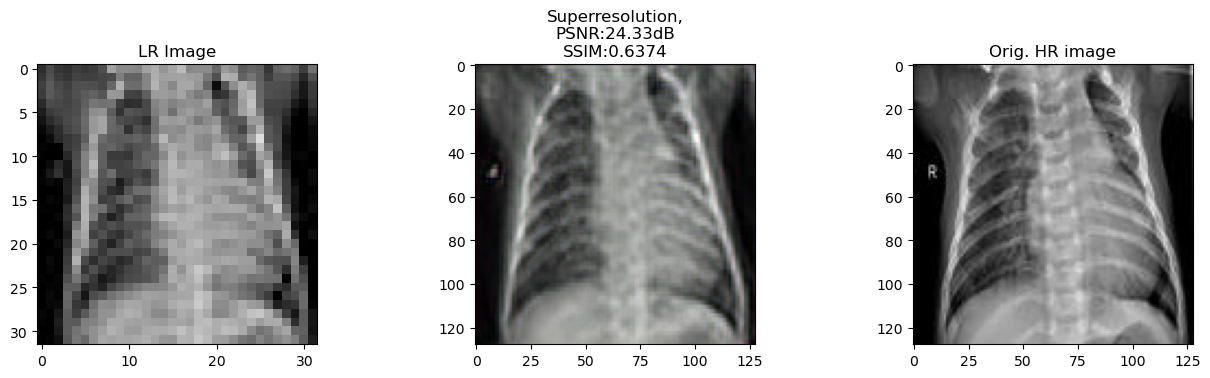

In [21]:
# plot all three images
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
#plt.imshow(sreeni_lr[0,:,:,:])
plt.imshow(np.clip(sreeni_lr[0,:,:,:],0,1))
plt.subplot(232)
plt.title('Superresolution,'+'\n'+psnr_title+'\n'+ssim_title)
#plt.imshow(generated_sreeni_hr[0,:,:,:])
plt.imshow(np.clip(generated_sreeni_hr[0,:,:,:],0,1))
plt.subplot(233)
plt.title('Orig. HR image')
#plt.imshow(sreeni_hr[0,:,:,:])
plt.imshow(np.clip(sreeni_hr[0,:,:,:],0,1))

plt.show()

In [22]:
d_losses

array([[2.84193189e-04, 1.00000000e+00],
       [2.10996237e-05, 1.00000000e+00],
       [2.22720296e-03, 1.00000000e+00],
       [7.98916295e-06, 1.00000000e+00],
       [1.77065008e-05, 1.00000000e+00],
       [2.74802503e-03, 1.00000000e+00],
       [1.12787386e-03, 1.00000000e+00],
       [3.40119555e-04, 1.00000000e+00],
       [1.78118734e-03, 1.00000000e+00],
       [5.64385703e-04, 1.00000000e+00],
       [6.50177954e-05, 1.00000000e+00],
       [8.24312956e-05, 1.00000000e+00],
       [4.12652644e-05, 1.00000000e+00],
       [1.43378619e-03, 1.00000000e+00],
       [2.19886449e-04, 1.00000000e+00],
       [1.31040122e-03, 1.00000000e+00],
       [1.52314994e-02, 1.00000000e+00]])

In [23]:
g_losses

array([5.94205713, 5.77069426, 5.74124861, 6.01272631, 5.94242764,
       5.47454643, 5.94236183, 5.92311907, 5.80984116, 5.67547607,
       5.88134336, 5.77973795, 5.57858133, 5.78303385, 5.86012077,
       6.33129025, 5.67093658])

In [26]:
dd=dis_losses_store
dd=[i[1] for i in dd]
    

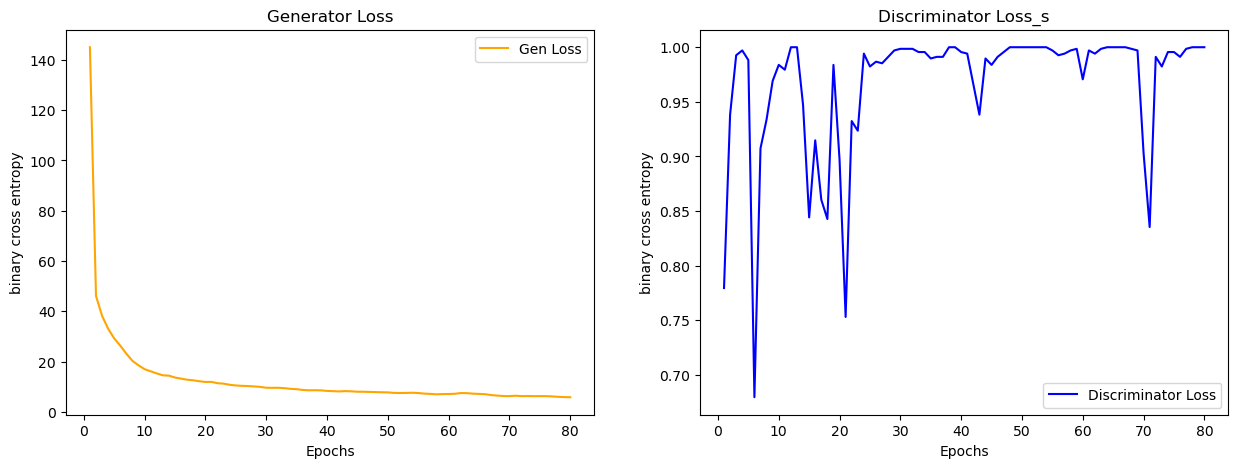

In [31]:
import matplotlib.pyplot as plt
epochs=range(1,len(gen_losses_store)+1)
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(epochs, gen_losses_store,'orange', label='Gen Loss')
plt.title('Generator Loss')
plt.xlabel('Epochs')
plt.ylabel('binary cross entropy')
plt.legend()


plt.subplot(1,2,2)
plt.plot(epochs, dd,'b', label='Discriminator Loss')
plt.title('Discriminator Loss_s')
plt.xlabel('Epochs')
plt.ylabel('binary cross entropy')
plt.legend()

#plt.savefig('plot.jpg',quality=95)
plt.show()
